In [13]:
%matplotlib inline 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import warnings
import itertools
from pylab import rcParams

df = pd.read_csv("../../dataset/cleaned.csv")

df.drop(['Unnamed: 0'], axis = 1, inplace = True)
df['Date'] = pd.to_datetime(df['Date'])
df['Time'] = pd.to_timedelta(df['Time'])
df['DateTime'] = pd.to_datetime(df['DateTime'])



In [81]:

minlyGAP = df.groupby('DateTime')['Global_active_power'].mean().reset_index()
minlyGAP = minlyGAP.set_index('DateTime')
minlyGAP.isnull().any()
weeklyGAP = minlyGAP['Global_active_power'].resample('W').sum()


Global_active_power    False
dtype: bool

**SARIMA model for prediction on weekly basis**

In [93]:
# Predicting on a weekly basis
# Trying to find the best parameters

season_duration = 52 #Because there are 52 weeks in a year

mod = sm.tsa.statespace.SARIMAX(weeklyGAP,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 52),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0694      0.108      0.643      0.520      -0.142       0.281
ma.L1         -0.9470      0.728     -1.300      0.193      -2.374       0.480
ar.S.L52      -0.1784      0.112     -1.596      0.111      -0.397       0.041
sigma2      6.548e+06   1.24e+06      5.273      0.000    4.11e+06    8.98e+06


**Model Diagnostics**

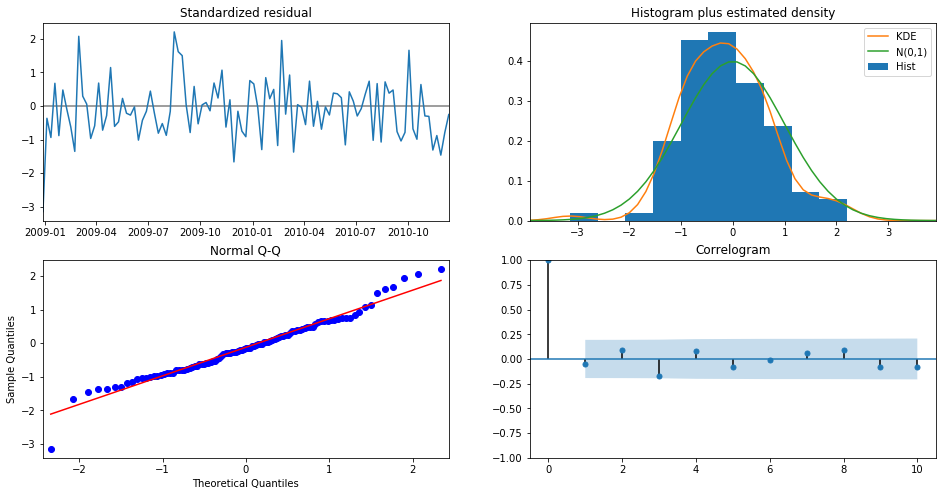

In [94]:
results.plot_diagnostics(figsize=(16,8))
plt.show()

**One Step Ahead forecast using the current model**

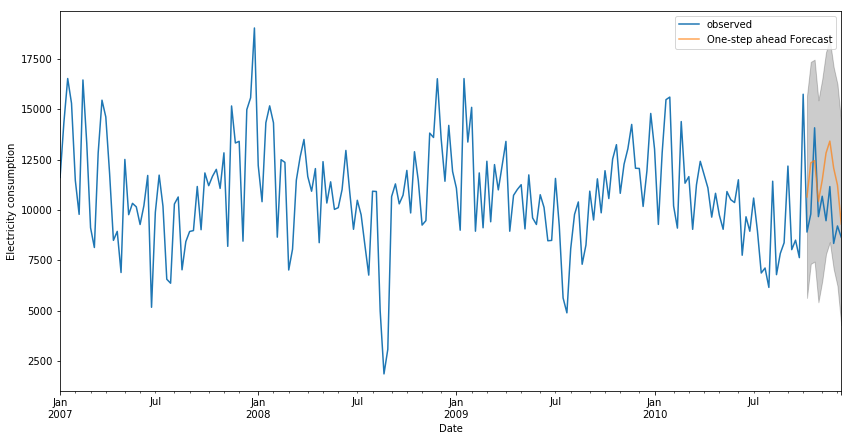

In [111]:
pred = results.get_prediction(start = '2010-10-10', dynamic=False)
pred_ci = pred.conf_int()

ax = weeklyGAP['2007':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Electricity consumption')
plt.legend()

plt.show()